In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sbibm.visualisation import fig_metric
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import numpy as np
import seaborn as sns
from typing import Any, Dict, List, Optional

from paper.utils import fig_metric_mpl, extract_diagnostic, fig_diagnostic

In [4]:
df = pd.read_pickle("../../results/results_thr3_compiled_with_lotka.pkl")

In [5]:
df1 = pd.read_csv("../../results/sbibm_results.csv")

In [25]:
npe_results = df1.query("algorithm == 'NPE'")
snpe_results = df1.query("algorithm == 'SNPE'")

In [26]:
all_results = pd.concat([df, npe_results, snpe_results])

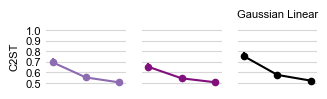

In [27]:
results_subset = all_results.query("task == 'gaussian_linear'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="Gaussian Linear", title=True, xlabel=False)
    plt.savefig("../svg/panel_a.svg", transparent=True)

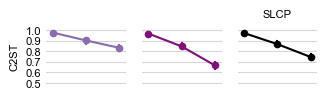

In [28]:
results_subset = all_results.query("task == 'slcp'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="SLCP", title=False, xlabel=False)
    plt.savefig("../svg/panel_b.svg", transparent=True)

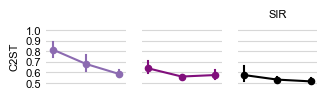

In [29]:
results_subset = all_results.query("task == 'sir'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="SIR", title=False, xlabel=False)
    plt.savefig("../svg/panel_c.svg", transparent=True)

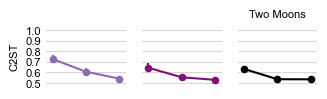

In [30]:
results_subset = all_results.query("task == 'two_moons'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="Two Moons", title=False, xlabel=False)
    plt.savefig("../svg/panel_d.svg", transparent=True)

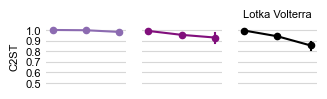

In [31]:
results_subset = all_results.query("task == 'lotka_volterra'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="Lotka Volterra", title=False, xlabel=False)
    plt.savefig("../svg/panel_e.svg", transparent=True)

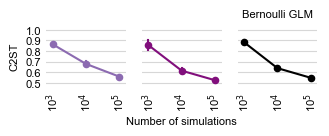

In [54]:
results_subset = all_results.query("task == 'bernoulli_glm'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="Bernoulli GLM", title=False, xlabel=True)
    plt.savefig("../svg/panel_f.svg", transparent=True)

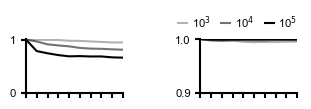

In [123]:
results_subset = all_results.query("task == 'gaussian_linear'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="Gaussian Linear", title=True, xlabel=False, legend=True)
    plt.savefig("../svg/panel_a2.svg", transparent=True)

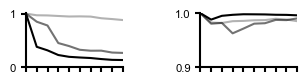

In [59]:
results_subset = all_results.query("task == 'slcp'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=False)
    plt.savefig("../svg/panel_b2.svg", transparent=True)

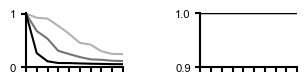

In [60]:
results_subset = all_results.query("task == 'sir'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=False)
    plt.savefig("../svg/panel_c2.svg", transparent=True)

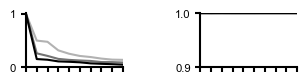

In [71]:
results_subset = all_results.query("task == 'two_moons'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=False, ylabel=False)
    plt.savefig("../svg/panel_d2.svg", transparent=True)

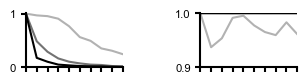

In [72]:
results_subset = all_results.query("task == 'lotka_volterra'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=False)
    plt.savefig("../svg/panel_e2.svg", transparent=True)

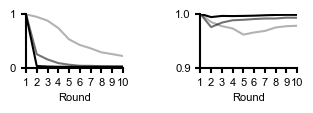

In [73]:
results_subset = all_results.query("task == 'bernoulli_glm'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=True)
    plt.savefig("../svg/panel_f2.svg", transparent=True)

In [64]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [124]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("15.7cm", "13.9cm",

    Panel(
          SVG("../svg/panel_a.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 10),
    Panel(
          SVG("../svg/panel_b.svg").scale(svg_scale).move(0, 0),
    ).move(-5,98),
    Panel(
          SVG("../svg/panel_c.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 176),
    Panel(
          SVG("../svg/panel_d.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 254),
    Panel(
          SVG("../svg/panel_e.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 332),
    Panel(
          SVG("../svg/panel_f.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 410),

    Text("NPE", 60, 10.0, **kwargs_text8pt),
    Text("SNPE", 145, 10.0, **kwargs_text8pt),
    Text("TSNPE", 228, 10.0, **kwargs_text8pt),
    Text("Acceptance rate", 340, 10.0, **kwargs_text8pt),
    Text("GT samples in support", 480, 10.0, **kwargs_text8pt),
    
    Panel(
          SVG("../svg/panel_a2.svg").scale(svg_scale).move(0, 0),
    ).move(314, 5),
    Panel(
          SVG("../svg/panel_b2.svg").scale(svg_scale).move(0, 0),
    ).move(314, 113),
    Panel(
          SVG("../svg/panel_c2.svg").scale(svg_scale).move(0, 0),
    ).move(314, 191),
    Panel(
          SVG("../svg/panel_d2.svg").scale(svg_scale).move(0, 0),
    ).move(314, 269),
    Panel(
          SVG("../svg/panel_e2.svg").scale(svg_scale).move(0, 0),
    ).move(314, 347),
    Panel(
          SVG("../svg/panel_f2.svg").scale(svg_scale).move(0, 0),
    ).move(314, 425),
)

f.save("../fig/fig4_higher_thr.svg")
svg('../fig/fig4_higher_thr.svg')